In [1]:
%cd ../..

C:\Users\Wight\PycharmProjects\ThesisMain


In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

from PIL import Image
import os
import models.ViCCT.ViCCTModels  # Need to register the models!
from timm.models import create_model
from datasets.dataset_utils import img_equal_unsplit
import importlib
import time

In [3]:
model_name = 'ViCCT_base_384'  # Must be something like 'deit_small_distilled_patch16_224'.
trained_model_path = 'D:\\OneDrive\\OneDrive - UvA\\ThesisData\\trained_models\\ViCCT base upscaled SHTB\\save_state_ep_940_new_best_MAE_5.858.pth'  # The path to trained model file (something like XYZ.pth)
label_factor = 3000  # The label factor used to train this specific model.
dataset = 'SHTB_ViCCT'  # Must be the exact name of the dataset
save_results = False  # When true, save the images, GTs and predictions. A folder for this is created automatically.
set_to_eval = 'test'  # val', 'test'. Which split to test the model on. 'train' does not work!

In [4]:
model = create_model(
        model_name,
        init_path=None,
        num_classes=1000,  # Not yet used anyway. Must match pretrained model!
        drop_rate=0.,
        drop_path_rate=0.,  
        drop_block_rate=None,
    )

model.cuda()

resume_state = torch.load(trained_model_path)
model.load_state_dict(resume_state['net'])

model.eval()

DistilledRegressionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU()
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attenti

In [5]:
dataloader = importlib.import_module(f'datasets.standard.{dataset}.loading_data').loading_data
cfg_data = importlib.import_module(f'datasets.standard.{dataset}.settings').cfg_data

train_loader, val_loader, test_loader, restore_transform = dataloader(model.crop_size)
if set_to_eval == 'val':
    my_dataloader = val_loader
elif set_to_eval == 'test':
    my_dataloader = test_loader
else:
    print(f'Error: invalid set --> {set_to_eval}')

320 train images found.
80 val images found.
316 test images found.


In [6]:
save_path = None
if save_results:
    save_folder = 'DeiT' + '_' + dataset + '_' + set_to_eval + '_' + time.strftime("%m-%d_%H-%M", time.localtime())
    save_path = os.path.join('notebooks', save_folder)  # Manually change here is you want to save somewhere else
    os.mkdir(save_path)

In [7]:
def plot_and_save_results(save_path, img, img_idx, gt, prediction, pred_cnt, gt_cnt):
    img_save_path = os.path.join(save_path, f'IMG_{img_idx}_AE_{abs(pred_cnt - gt_cnt):.3f}.jpg')
    
    plt.figure()
    f, axarr = plt.subplots(1, 3, figsize=(13, 13))
    axarr[0].imshow(img)
    axarr[1].imshow(gt, cmap=cm.jet)
    axarr[1].title.set_text(f'GT count: {gt_cnt:.3f}')
    axarr[2].imshow(prediction, cmap=cm.jet)
    axarr[2].title.set_text(f'predicted count: {pred_cnt:.3f}')
    plt.tight_layout()
    plt.savefig(img_save_path)
    plt.close('all')

In [8]:
def eval_model(model, my_dataloader, show_predictions, restore_transform, label_factor, cfg_data):
    with torch.no_grad():
        AEs = []  # Absolute Errors
        SEs = []  # Squared Errors
        GTs = []
        preds = []

        for idx, (img, img_patches, gt_patches) in enumerate(my_dataloader):
            img_patches = img_patches.squeeze().cuda()
            gt_patches = gt_patches.squeeze().unsqueeze(1)  # Remove batch dim, insert channel dim
            img = img.squeeze()  # Remove batch dimension
            _, img_h, img_w = img.shape  # Obtain image dimensions. Used to reconstruct GT and Prediction
            
            img = restore_transform(img)

            pred_den = model(img_patches)  # Precicted density crops
            pred_den = pred_den.cpu()

            # Restore GT and Prediction
            gt = img_equal_unsplit(gt_patches, cfg_data.OVERLAP, cfg_data.IGNORE_BUFFER, img_h, img_w, 1)
            den = img_equal_unsplit(pred_den, cfg_data.OVERLAP, cfg_data.IGNORE_BUFFER, img_h, img_w, 1)
            gt = gt.squeeze()  # Remove channel dim
            den = den.squeeze()  # Remove channel dim
            
            
            pred_cnt = den.sum() / label_factor
            gt_cnt = gt.sum() / cfg_data.LABEL_FACTOR
            
            AEs.append(torch.abs(pred_cnt - gt_cnt).item())
            SEs.append(torch.square(pred_cnt - gt_cnt).item())
            GTs.append(gt_cnt.item())
            preds.append(pred_cnt.item())
            relative_error = AEs[-1] / gt_cnt * 100
            print(f'IMG {idx:<3} '
                  f'Prediction: {pred_cnt:<9.3f} '
                  f'GT: {gt_cnt:<9.3f} '
                  f'Absolute Error: {AEs[-1]:<9.3f} '
                  f'Relative Error: {relative_error:.1f}%')
            
            if save_path:
                plot_and_save_results(save_path, img, idx, gt, den, pred_cnt, gt_cnt)
            
        MAE = np.mean(AEs)
        MSE = np.sqrt(np.mean(SEs))

    return MAE, MSE, GTs, preds

In [ ]:
MAE, MSE, GTs, preds = eval_model(model, my_dataloader, save_path, restore_transform, label_factor, cfg_data)
print(f'MAE/MSE: {MAE:.3f}/{MSE:.3f}')

IMG 0   Prediction: 21.944    GT: 22.930    Absolute Error: 0.986     Relative Error: 4.3%
IMG 1   Prediction: 164.737   GT: 178.575   Absolute Error: 13.838    Relative Error: 7.7%
IMG 2   Prediction: 135.419   GT: 156.916   Absolute Error: 21.498    Relative Error: 13.7%
IMG 3   Prediction: 33.930    GT: 36.641    Absolute Error: 2.711     Relative Error: 7.4%
IMG 4   Prediction: 67.081    GT: 69.678    Absolute Error: 2.597     Relative Error: 3.7%
IMG 5   Prediction: 58.785    GT: 56.930    Absolute Error: 1.855     Relative Error: 3.3%
IMG 6   Prediction: 42.083    GT: 43.860    Absolute Error: 1.778     Relative Error: 4.1%
IMG 7   Prediction: 221.445   GT: 224.494   Absolute Error: 3.049     Relative Error: 1.4%
IMG 8   Prediction: 171.080   GT: 164.729   Absolute Error: 6.351     Relative Error: 3.9%
IMG 9   Prediction: 496.821   GT: 474.624   Absolute Error: 22.197    Relative Error: 4.7%
IMG 10  Prediction: 140.953   GT: 138.824   Absolute Error: 2.129     Relative Error: 1.5

IMG 90  Prediction: 103.097   GT: 100.175   Absolute Error: 2.921     Relative Error: 2.9%
IMG 91  Prediction: 59.166    GT: 59.964    Absolute Error: 0.797     Relative Error: 1.3%
IMG 92  Prediction: 235.289   GT: 250.483   Absolute Error: 15.194    Relative Error: 6.1%
IMG 93  Prediction: 174.477   GT: 186.611   Absolute Error: 12.134    Relative Error: 6.5%
IMG 94  Prediction: 187.933   GT: 183.354   Absolute Error: 4.579     Relative Error: 2.5%
IMG 95  Prediction: 102.079   GT: 105.446   Absolute Error: 3.367     Relative Error: 3.2%
IMG 96  Prediction: 96.820    GT: 103.138   Absolute Error: 6.318     Relative Error: 6.1%
IMG 97  Prediction: 146.515   GT: 159.000   Absolute Error: 12.485    Relative Error: 7.9%
IMG 98  Prediction: 56.416    GT: 56.000    Absolute Error: 0.416     Relative Error: 0.7%
IMG 99  Prediction: 39.267    GT: 39.207    Absolute Error: 0.060     Relative Error: 0.2%
IMG 100 Prediction: 270.730   GT: 276.673   Absolute Error: 5.943     Relative Error: 2.1%

IMG 180 Prediction: 174.270   GT: 183.371   Absolute Error: 9.100     Relative Error: 5.0%
IMG 181 Prediction: 128.119   GT: 137.000   Absolute Error: 8.881     Relative Error: 6.5%
IMG 182 Prediction: 99.311    GT: 95.000    Absolute Error: 4.311     Relative Error: 4.5%
IMG 183 Prediction: 30.007    GT: 36.000    Absolute Error: 5.993     Relative Error: 16.6%
IMG 184 Prediction: 26.364    GT: 27.233    Absolute Error: 0.870     Relative Error: 3.2%
IMG 185 Prediction: 55.610    GT: 58.563    Absolute Error: 2.953     Relative Error: 5.0%
IMG 186 Prediction: 66.223    GT: 61.611    Absolute Error: 4.612     Relative Error: 7.5%
IMG 187 Prediction: 79.051    GT: 78.880    Absolute Error: 0.171     Relative Error: 0.2%
IMG 188 Prediction: 344.353   GT: 302.890   Absolute Error: 41.463    Relative Error: 13.7%
IMG 189 Prediction: 210.808   GT: 206.883   Absolute Error: 3.925     Relative Error: 1.9%
IMG 190 Prediction: 145.255   GT: 141.153   Absolute Error: 4.102     Relative Error: 2.

IMG 270 Prediction: 101.770   GT: 95.245    Absolute Error: 6.525     Relative Error: 6.9%
IMG 271 Prediction: 42.182    GT: 47.743    Absolute Error: 5.560     Relative Error: 11.6%
IMG 272 Prediction: 209.610   GT: 194.752   Absolute Error: 14.858    Relative Error: 7.6%
IMG 273 Prediction: 30.630    GT: 33.414    Absolute Error: 2.784     Relative Error: 8.3%
IMG 274 Prediction: 430.798   GT: 408.728   Absolute Error: 22.070    Relative Error: 5.4%
IMG 275 Prediction: 171.218   GT: 171.548   Absolute Error: 0.329     Relative Error: 0.2%
IMG 276 Prediction: 59.732    GT: 59.589    Absolute Error: 0.143     Relative Error: 0.2%
IMG 277 Prediction: 47.530    GT: 49.137    Absolute Error: 1.607     Relative Error: 3.3%
IMG 278 Prediction: 231.465   GT: 231.781   Absolute Error: 0.316     Relative Error: 0.1%
IMG 279 Prediction: 167.061   GT: 173.766   Absolute Error: 6.705     Relative Error: 3.9%
IMG 280 Prediction: 109.324   GT: 107.652   Absolute Error: 1.672     Relative Error: 1.6

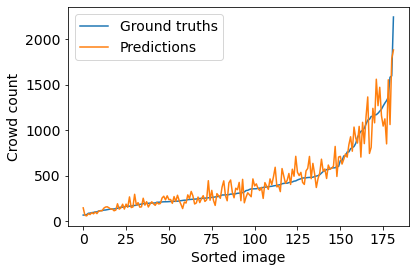

In [10]:
img_nrs = np.arange(len(GTs))
sorted_idxs = np.argsort(GTs)
GTs = np.array(GTs)
preds = np.array(preds)

plt.rcParams.update({'font.size': 14})

plt.figure()
plt.plot(img_nrs, GTs[sorted_idxs], label='Ground truths')
plt.plot(img_nrs, preds[sorted_idxs], label='Predictions')
plt.ylabel('Crowd count')
plt.xlabel('Sorted image')
plt.legend()
plt.tight_layout()
# plt.savefig(f'DeiT_{dataset}_pred_vs_gt.jpg')
plt.show()

In [ ]:
img_nrs = np.arange(len(GTs))
sorted_idxs = np.argsort(GTs)
GTs = np.array(GTs)
preds = np.array(preds)

plt.rcParams.update({'font.size': 14})

plt.figure()
plt.plot(img_nrs, GTs[sorted_idxs], label='Ground truths')
plt.plot(img_nrs, preds[sorted_idxs], label='Predictions')
plt.ylabel('Crowd count')
plt.xlabel('Sorted image')
plt.legend()
plt.tight_layout()
# plt.savefig(f'DeiT_{dataset}_pred_vs_gt.jpg')
plt.show()

In [ ]:
sorted_error_idxs = np.flip(np.argsort(np.abs(GTs - preds)))

with torch.no_grad():
    for idx in sorted_error_idxs[:10]:
        img, img_patches, gt_patches = my_dataloader.dataset.__getitem__(idx)

        img_patches = img_patches.cuda()
        gt_patches = gt_patches.squeeze().unsqueeze(1)  # Remove batch dim, insert channel dim
        img = img.squeeze()  # Remove batch dimension
        _, img_h, img_w = img.shape  # Obtain image dimensions. Used to reconstruct GT and Prediction

        img = restore_transform(img)

        pred_den = model(img_patches)  # Precicted density crops
        pred_den = pred_den.cpu()
        
        # Restore GT and Prediction
        gt = img_equal_unsplit(gt_patches, cfg_data.OVERLAP, cfg_data.IGNORE_BUFFER, img_h, img_w, 1)
        den = img_equal_unsplit(pred_den, cfg_data.OVERLAP, cfg_data.IGNORE_BUFFER, img_h, img_w, 1)
        gt = gt.squeeze()  # Remove channel dim
        den = den.squeeze()  # Remove channel dim


        pred_cnt = den.sum() / label_factor
        gt_cnt = gt.sum() / cfg_data.LABEL_FACTOR

        print(f'IMG {idx}, pred: {pred_cnt:.3f}, gt: {gt_cnt:.3f}. Error: {pred_cnt - gt_cnt:.3f}')
        
        plt.figure()
        plt.imshow(np.asarray(img))
#         plt.savefig(f'DeiT_IMG_{idx + 1}_{dataset}.jpg')
        plt.show()
        
        
        plt.figure()
        plt.imshow(den.numpy(), cmap=cm.jet)
        plt.title(f'Predicted count: {pred_cnt:.3f}')
#         plt.savefig(f'DeiT_IMG_{idx + 1}_{dataset}_prediction.jpg')
        plt.show()

In [ ]:
sorted_good_idxs = np.argsort(np.abs(GTs - preds))

with torch.no_grad():
    for idx in sorted_good_idxs[:10]:
        img, img_patches, gt_patches = my_dataloader.dataset.__getitem__(idx)

        img_patches = img_patches.cuda()
        gt_patches = gt_patches.squeeze().unsqueeze(1)  # Remove batch dim, insert channel dim
        img = img.squeeze()  # Remove batch dimension
        _, img_h, img_w = img.shape  # Obtain image dimensions. Used to reconstruct GT and Prediction

        img = restore_transform(img)

        pred_den = model(img_patches)  # Precicted density crops
        pred_den = pred_den.cpu()
        
        # Restore GT and Prediction
        gt = img_equal_unsplit(gt_patches, cfg_data.OVERLAP, cfg_data.IGNORE_BUFFER, img_h, img_w, 1)
        den = img_equal_unsplit(pred_den, cfg_data.OVERLAP, cfg_data.IGNORE_BUFFER, img_h, img_w, 1)
        gt = gt.squeeze()  # Remove channel dim
        den = den.squeeze()  # Remove channel dim


        pred_cnt = den.sum() / label_factor
        gt_cnt = gt.sum() / cfg_data.LABEL_FACTOR

        print(f'IMG {idx}, pred: {pred_cnt:.3f}, gt: {gt_cnt:.3f}. Error: {pred_cnt - gt_cnt:.3f}')
        
        plt.figure()
        plt.imshow(np.asarray(img))
#         plt.savefig(f'DeiT_IMG_{idx + 1}_{dataset}.jpg')
        plt.show()
        
        
        plt.figure()
        plt.imshow(den.numpy(), cmap=cm.jet)
        plt.title(f'Predicted count: {pred_cnt:.3f}')
#         plt.savefig(f'DeiT_IMG_{idx + 1}_{dataset}_prediction.jpg')
        plt.show()